# Automatic differentiation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nhartman94/PALMS2024/blob/main/Automatic-differentiation.ipynb)


What's the "magic sauce" that helps NNs train? Auto-diff! These are the frameworks that modern deep learning libraries such as jax, pytorch, and tensorflow are written in.

And we'll dive into what auto-diff means and how to get gradients in jax.

In [1]:
import jax
from jax import grad
import jax.numpy as jnp

import matplotlib.pyplot as plt

Let's check how jax gets gradients automatically!

Let's start with a very simple toy example:

$$z = x * y$$

In [2]:
def z(x,y): 
    return x * y

Let $x=1$ and $y=2$, and check the program evaluation.

In [3]:
x=1.
y=2.

z(x,y)

2.0

OK, so let's let auto-diff do it's magic and calculate the gradient for us!!

In [4]:
dz = grad(z)(x,y)
dz

Array(2., dtype=float32, weak_type=True)

Why 2? B/c jax is automatically computing the gradient w/r.t. the _first_ argument $x$, and $dz/dx = y = 2$

Is there a way we can also get the gradient w/r.t. the other inputs too? 

Yep! There's two ways we can do this.

1. By the positional arguments

In [5]:
grad(z,argnums=(0,1))(x,y)

(Array(2., dtype=float32, weak_type=True),
 Array(1., dtype=float32, weak_type=True))

A.k.a, what this is saying is 

$$\left. \frac{\partial z}{\partial x}\right\vert_{x,y=(1,2)} = y = 2$$
$$\left. \frac{\partial z}{\partial y}\right\vert_{x,y=(1,2)} = x = 1$$

2. By evaluating with a dictionary

Alternatively, if we pass a _dictionary_ to the function we're creating, we can get all the gradients at once!

In [6]:
def z2(param_dict):
    x = param_dict['x']
    y = param_dict['y']
    return x * y

In [7]:
# Sanity check the forward pass is the same
z2({'x':x,'y':y})

2.0

In [8]:
# and get the gradients
grad(z2)({'x':x,'y':y})

{'x': Array(2., dtype=float32, weak_type=True),
 'y': Array(1., dtype=float32, weak_type=True)}

Again, it matches our expectation!!

## Build a mini NN in jax

OK, now that we know how to calculate gradients w/r.t. multiple inputs, we're ready to build (and train) our mini NN.

If you know numpy, coding in jax is (mostly) easy! Just replace `np` with `jnp`.

**Step 1:** Code up the forward pass for a single layer NN.

In [9]:
def myNN(param_dict, X):
    '''
    param_dict: dictionary (keys W1, b1, W2, b2)
    x: The input vector
    '''

    W1 = param_dict["W1"]
    b1 = param_dict["b1"]

    W2 = param_dict["W2"]
    b2 = param_dict["b2"]

    # Fill in the forward pass for the NN
    '''
    YOUR CODE HERE
    '''
    
    return out

Note, `param_dict` is the first arg to the NN as jax wants to differentiate w/r.t. the first input.

**Initialize the parameters of the NN**

Note, jax always needs specify a key for generating random numbers, and that's what the lines below are doing.

To match the previous ex, suppose that our NN has 1d input and output, and 20 hidden neurons.

In [10]:
key = jax.random.key(0)
key, W1_key, b1_key, W2_key, b2_key = jax.random.split(key, 5)

nHidden=1600

W1 = jax.random.normal(W1_key, (1,nHidden))
b1 = jax.random.normal(b1_key, (1,nHidden,))

W2 = jax.random.normal(W2_key, (nHidden,1))
b2 = jax.random.normal(b2_key, ())

param_dict = {
    'W1':W1,
    'b1':b1,
    'W2':W2,
    'b2':b2,
}

**The target function we're looking at**

In [18]:
def f(x):
    return x**3-.3*x**4-2*jnp.sin(x)

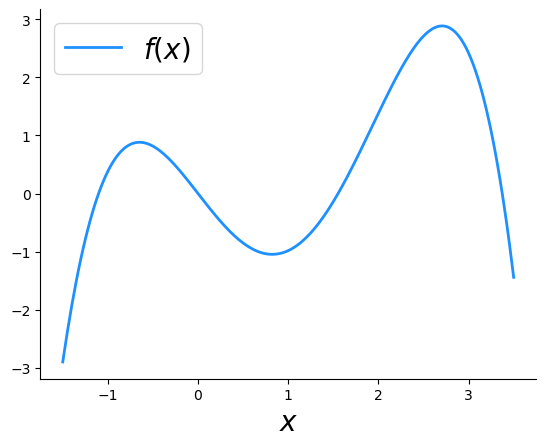

In [19]:
xx = jnp.linspace(-1.5,3.5,201)
plt.plot(xx,f(xx),color='dodgerblue',lw=2,label='$f(x)$')
plt.xlabel('$x$',fontsize=20)
plt.legend(fontsize=20)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Before we trained the model at all, let's evaluate the prediction.

In [20]:
xx[:,None].shape

(201, 1)

In [21]:
y_out = myNN(param_dict,xx[:,None])

In [1]:
xx = jnp.linspace(-1.5,3.5,201)
plt.plot(xx,f(xx),color='dodgerblue',lw=2,label='$f(x)$')
plt.plot(xx,y_out,color='lightgrey',lw=2,label='Untrained NN')
plt.xlabel('$x$',fontsize=20)
plt.legend(fontsize=20)
plt.ylim(-3,6)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

NameError: name 'jnp' is not defined

**The (x,y) labels for training the NN?**

- Sample $x$ from [0,1]
- Evaluate as $y =f(x)$
- Add noise to these $y$ values


In [23]:
def make_batch(key,N=32):
    
    x = jax.random.uniform(key,(N,1),minval=-1.5,maxval=3.5)
    y = f(x)
    
    key,subkey = jax.random.split(key)
    eps = 0.02 * jax.random.normal(subkey,(N,1))

    y+=eps

    return x,y

In [24]:
# Sample from the batch
key,subkey = jax.random.split(key, 2)
x,y = make_batch(subkey)

In [25]:
x.shape, y.shape

((32, 1), (32, 1))

Look at the data, overlay the batch samples on the plot

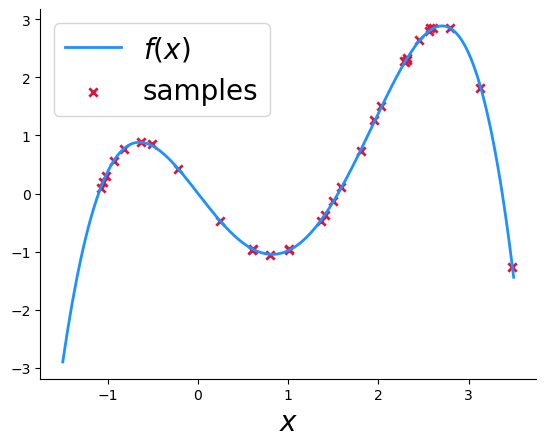

In [26]:
plt.plot(xx,f(xx),color='dodgerblue',lw=2,label='$f(x)$')
plt.scatter(x,y,marker='x',color='crimson',lw=2,label='samples')
plt.xlabel('$x$',fontsize=20)
plt.legend(fontsize=20)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

OK, from here we're ready to setup a training loop!!

In [27]:
def mse_loss(param_dict,x,y):
    '''
    Calculate the MSE loss
    '''

    # Evaluate model
    y_pred = myNN(param_dict,x)
    
    # Calculate loss
    L = jnp.mean((y_pred - y)**2)

    return L


In [28]:
alpha=3e-4 # learning rate
losses = []

for i in range(1001):

    # Sample batch
    key,subkey = jax.random.split(key, 2)
    x,y = make_batch(subkey)

    # Calculate the loss
    L =  mse_loss(param_dict,x,y)
    
    # Get gradients
    dLoss = grad(mse_loss)(param_dict,x,y)
    
    # Update parameters
    param_dict["W1"] -= alpha * dLoss["W1"]
    param_dict["b1"] -= alpha * dLoss["b1"]
    param_dict["W2"] -= alpha * dLoss["W2"]
    param_dict["b2"] -= alpha * dLoss["b2"]
    
    # append loss
    losses.append(L)

**Plot the final loss predictions:**

(0.0, 1.0)

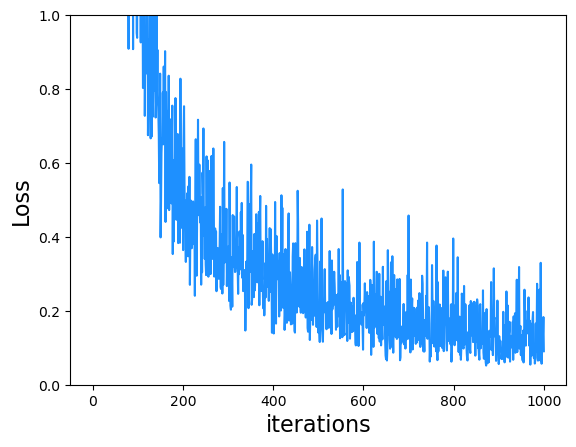

In [29]:
plt.plot(losses,color='dodgerblue')
plt.xlabel('iterations',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.ylim(0,1)

**Look at the final model prediction**

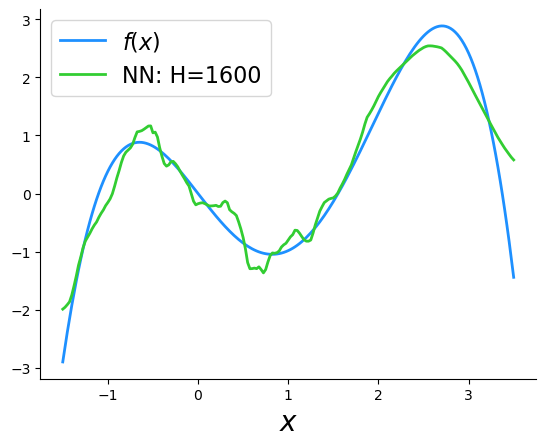

In [30]:
plt.plot(xx,f(xx),color='dodgerblue',lw=2,label='$f(x)$')

y_out = myNN(param_dict,xx[:,None])
plt.plot(xx,y_out,color='limegreen',lw=2,label=f'NN: H={nHidden}')
plt.xlabel('$x$',fontsize=20)
plt.legend(fontsize=16)
# plt.ylim(0,1)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

It doesn't look so good right out of the box... do you have ideas from what you learned today how to improve the model performance?

**Soln:** Increase the number of hidden nodes :) 1600 was better for me.

**Bonus:** What about increasing the depth of the NN?

Tomorrow with Carol you'll learn some of the packages in jax that streamlines some of this boiler plate code, but we've gone over a lot of basic concepts today, so ... should be good to go!!

**Further resources:**
- For more details, see L. Heinrich's [AD tutorial](https://github.com/lukasheinrich/pyhep2020-autodiff-tutorial?tab=readme-ov-file)
- See also the jax [Getting Started](https://jax.readthedocs.io/en/latest/beginner_guide.html#beginner-guide) tutorial.